# Greenness (gcc) Predictions:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
import pickle
pdf = matplotlib.backends.backend_pdf.PdfPages("PEG_RFR2_GCC_Predictions_Plots.pdf")

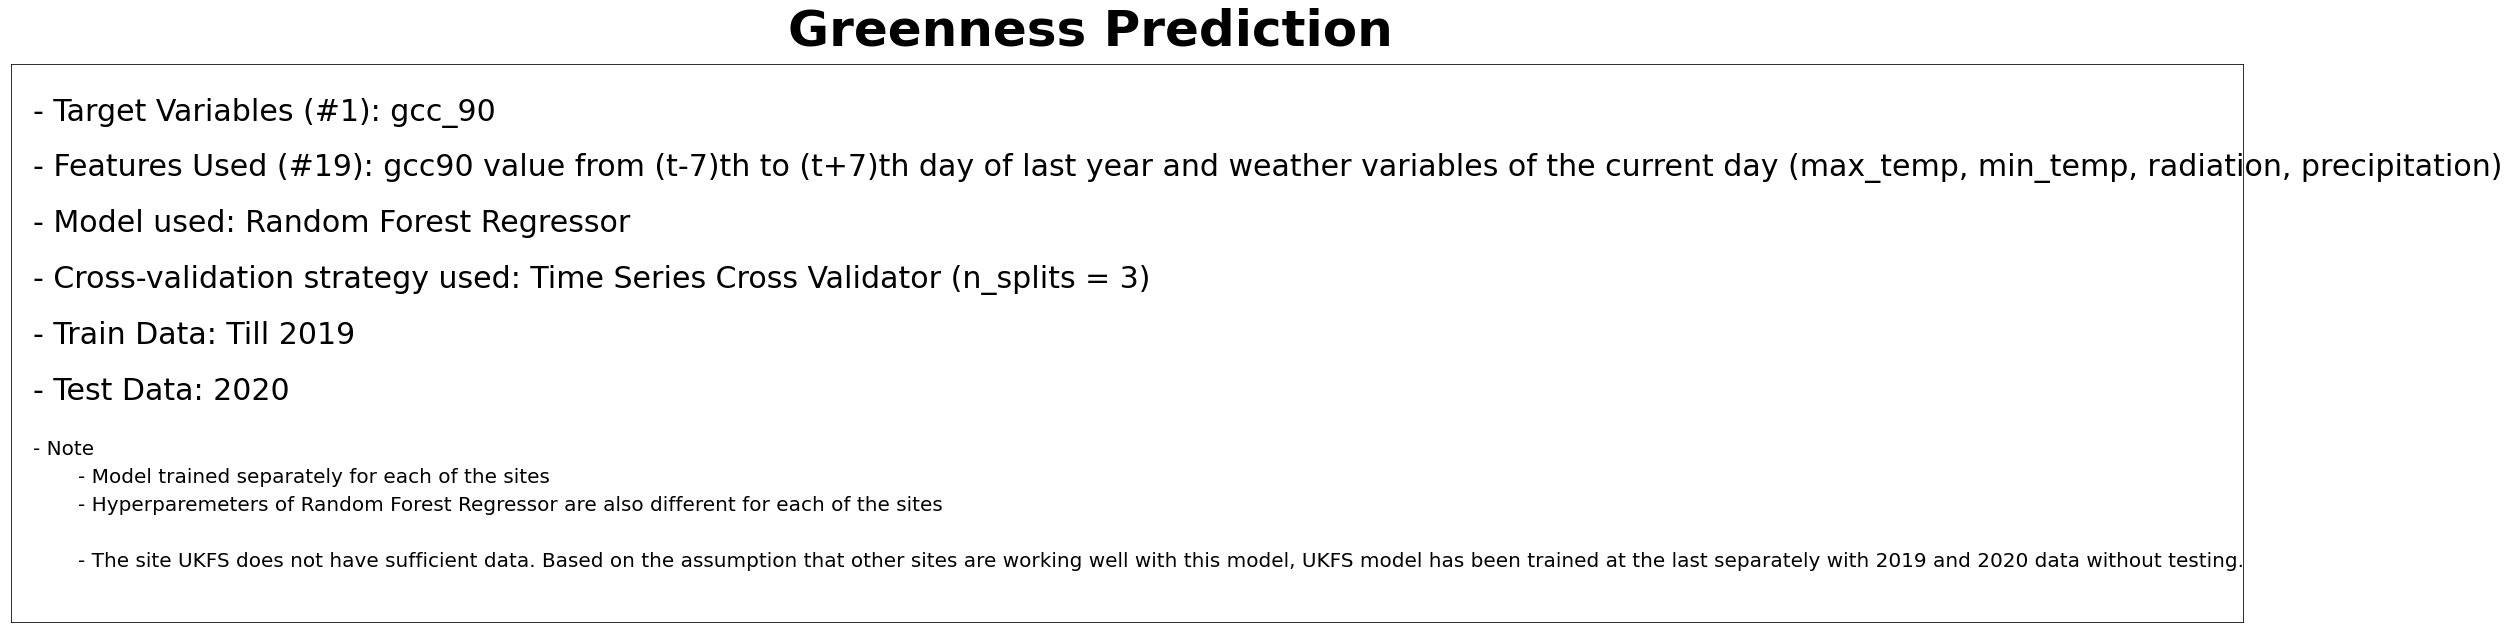

In [3]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Greenness Prediction', fontsize = 50, fontweight='bold')
#ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(0.01, 0.9, '- Target Variables (#1): gcc_90', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.8, '- Features Used (#19): gcc90 value from (t-7)th to (t+7)th day of last year and weather variables of the current day (max_temp, min_temp, radiation, precipitation)', 
         fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.7, '- Model used: Random Forest Regressor', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.6, '- Cross-validation strategy used: Time Series Cross Validator (n_splits = 3)', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.5, '- Train Data: Till 2019', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.4, '- Test Data: 2020', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.3, '- Note', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.25, '- Model trained separately for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.2, '- Hyperparemeters of Random Forest Regressor are also different for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.1, '- The site UKFS does not have sufficient data. Based on the assumption that other sites are working well with this model, UKFS model has been trained at the last separately with 2019 and 2020 data without testing.', fontsize = 20, horizontalalignment = 'left')
pdf.savefig()

## Data Preparation

In [4]:
# Importing the dataset targets_gcc.csv
url = "https://raw.githubusercontent.com/genophenoenvo/neon-datasets/main/pheno_images/targets_gcc.csv"
target_gcc_data = pd.read_csv(url)
print("Shape of imported dataset:" + str(target_gcc_data.shape))
print("\nColumns of imported dataset:")
print(target_gcc_data.columns)

Shape of imported dataset:(12496, 4)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'gcc_sd'], dtype='object')


In [8]:
#Importing weather dataset
url = "Daymet_weather.csv"
weather_data = pd.read_csv(url)
print("Shape of imported dataset:" + str(weather_data.shape))
print("\nColumns of imported dataset:")
print(weather_data.columns)

Shape of imported dataset:(14600, 6)

Columns of imported dataset:
Index(['siteID', 'time', 'radiation', 'max_temp', 'min_temp', 'precip'], dtype='object')


In [9]:
# Merging gcc and weather data
dataset = pd.merge(left = target_gcc_data, right = weather_data, how='outer', left_on=['time','siteID'], right_on=['time','siteID'])
dataset

,time,siteID,gcc_90,gcc_sd,radiation,max_temp,min_temp,precip
0,2016-12-13,HARV,0.32901,0.000214,3.612328,2.42,-3.12,2.60
1,2016-12-14,HARV,0.32811,0.000146,5.534190,0.64,-5.64,0.00
2,2016-12-15,HARV,0.32955,0.000463,3.550909,-6.91,-10.52,0.00
3,2016-12-16,HARV,0.32874,0.000329,7.992618,-8.23,-20.13,0.00
4,2016-12-17,HARV,0.33152,0.000355,6.465979,3.23,-19.47,19.89
...,...,...,...,...,...,...,...,...
15267,2016-12-08,UKFS,NaN,NaN,5.722398,-3.37,-10.63,0.00
15268,2016-12-09,UKFS,NaN,NaN,8.050261,-0.92,-12.30,0.00
15269,2016-12-10,UKFS,NaN,NaN,8.816213,5.33,-8.26,0.00
15270,2016-12-11,UKFS,NaN,NaN,6.992233,4.46,-4.93,0.00


In [10]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
dataset = dataset.set_index("time")

In [13]:
# Selecting the required columns: siteID and gcc90 and date related columns
gcc_data = dataset[["year", "month", "day", "year_month", "siteID", "gcc_90", "radiation", "max_temp", "min_temp", "precip"]]
print("Shape:" + str(gcc_data.shape))
site_list = gcc_data["siteID"].unique()
print("Sites:")
print(site_list)
gcc_data

Shape:(15272, 10)
Sites:
['HARV' 'BART' 'SCBI' 'STEI' 'UKFS' 'GRSM' 'DELA' 'CLBJ']


,year,month,day,year_month,siteID,gcc_90,radiation,max_temp,min_temp,precip
time,,,,,,,,,,
2016-12-13,2016,12,13,2016-12,HARV,0.32901,3.612328,2.42,-3.12,2.60
2016-12-14,2016,12,14,2016-12,HARV,0.32811,5.534190,0.64,-5.64,0.00
2016-12-15,2016,12,15,2016-12,HARV,0.32955,3.550909,-6.91,-10.52,0.00
2016-12-16,2016,12,16,2016-12,HARV,0.32874,7.992618,-8.23,-20.13,0.00
2016-12-17,2016,12,17,2016-12,HARV,0.33152,6.465979,3.23,-19.47,19.89
...,...,...,...,...,...,...,...,...,...,...
2016-12-08,2016,12,8,2016-12,UKFS,NaN,5.722398,-3.37,-10.63,0.00
2016-12-09,2016,12,9,2016-12,UKFS,NaN,8.050261,-0.92,-12.30,0.00
2016-12-10,2016,12,10,2016-12,UKFS,NaN,8.816213,5.33,-8.26,0.00


In [14]:
#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
site_data = []
for i in range(0,8):
    site_data.append(gcc_data_by_site.get_group(site_list[i]))

In [15]:
#Creating features by using shift() function
input_features = ['radiation', 'max_temp', 'min_temp', 'precip']
target_variables = ['gcc_90']
for k in range(0,8):
    for i in range(1,8):     #Creating features columns for last 7 days from last year
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        site_data[k].loc[:,col_name_last_year] = site_data[k].loc[:,"gcc_90"].shift(i+365)
        
    for i in range(0,8):     #Creating features columns for t to (t+7) days from last year
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        site_data[k].loc[:,col_name_last_year_ahead] = site_data[k].loc[:,"gcc_90"].shift(365-i)

C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [16]:
print("Columns in each of the site's dataframe:")
site_data[0].columns

Columns in each of the site's dataframe:


Index(['year', 'month', 'day', 'year_month', 'siteID', 'gcc_90', 'radiation',
       'max_temp', 'min_temp', 'precip', 'last_year_gcc_90_(t-1)',
       'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)',
       'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)',
       'last_year_gcc_90_(t-6)', 'last_year_gcc_90_(t-7)',
       'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)',
       'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)',
       'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)',
       'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)'],
      dtype='object')

In [17]:
print("Input Features:\n" + str(input_features))
print("\nTarget Variables:\n" + str(target_variables))

Input Features:
['radiation', 'max_temp', 'min_temp', 'precip', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t-6)', 'last_year_gcc_90_(t-7)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)']

Target Variables:
['gcc_90']


In [18]:
# Calculating baseline gcc_90 for comparison (baseline gcc_90 = average of last 3 years gcc_90 value)
for k in range(0,8):
    df =  site_data[k].copy()
    
    df.drop(pd.Timestamp("2020-02-29"), inplace = True, errors = 'ignore')
    
    baseline_df = df[["siteID"]]
    avg = pd.DataFrame()
    
    avg["ly_1"] = df.loc[:, "gcc_90"].shift(365)
    avg["ly_2"] = df.loc[:, "gcc_90"].shift(365*2)
    avg["ly_3"] = df.loc[:, "gcc_90"].shift(365*3)
    avg["mean"] = avg.mean(axis = 1, skipna = True)
    baseline_df["baseline_gcc_90"] = avg["mean"]
    baseline_df.drop("siteID", inplace = True, axis =1)
    site_data[k] = site_data[k].join(baseline_df, how ='outer')

<ipython-input-18-d1ca49cd8e6d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["baseline_gcc_90"] = avg["mean"]
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
# Keeping current year data aside to make predictions later after the model being trained.
current_year_data = []
for k in range(0,8):
    current_year_data.append(site_data[k].loc['2021', :].dropna(subset = input_features))

In [20]:
#drop missing values
for k in range(0,8):
    site_data[k].dropna(subset = input_features + target_variables, inplace = True)

In [21]:
# data count for each year after dropping missing values
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,8):
    data_count[site_list[k]] =  site_data[k].groupby("year").count().iloc[:, 1]
data_count

,HARV,BART,SCBI,STEI,UKFS,GRSM,DELA,CLBJ
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,10.0,11.0,12.0,NaN,NaN,NaN,9.0,NaN
2018,303.0,272.0,296.0,36.0,NaN,242.0,311.0,18.0
2019,346.0,299.0,253.0,340.0,41.0,350.0,361.0,327.0
2020,272.0,271.0,331.0,334.0,253.0,298.0,325.0,357.0
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


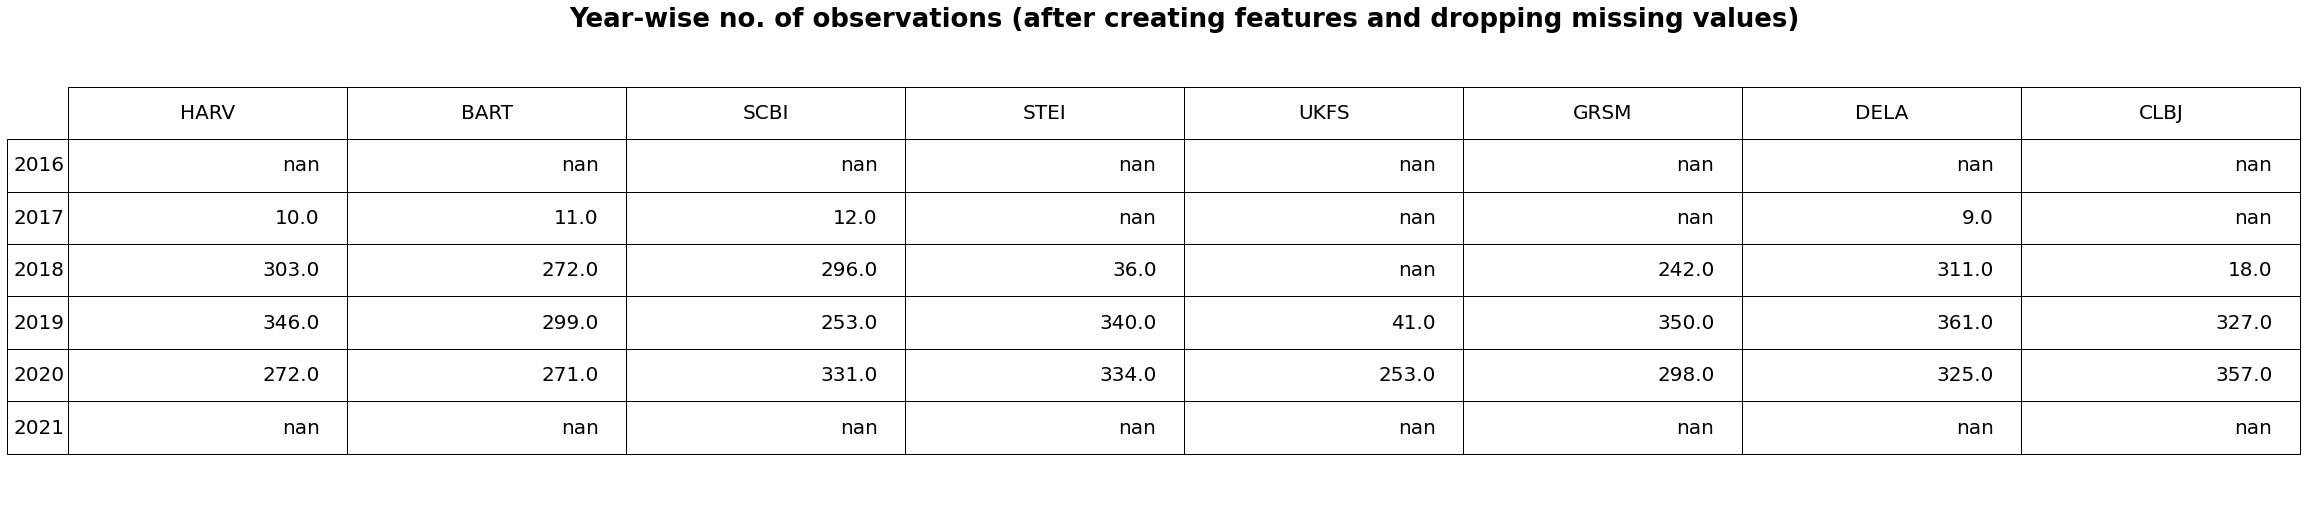

In [22]:
plt.figure(figsize=(40,8))
table = plt.table(np.array(data_count), rowLabels = [2016, 2017, 2018, 2019, 2020, 2021],
                      colLabels = site_list,
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values)", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()
pdf.savefig()

## Training

LR: -0.015133 (0.005409)
KNN: -0.027075 (0.002498)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.016636 (0.004974)
SVR: -0.045401 (0.009063)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

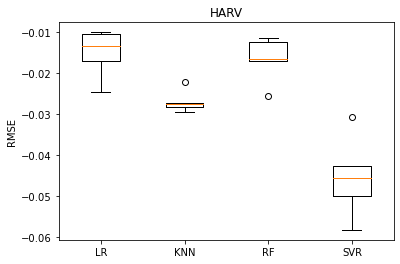

LR: -0.011375 (0.004904)
KNN: -0.024670 (0.006008)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.011734 (0.006308)
SVR: -0.045154 (0.008057)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

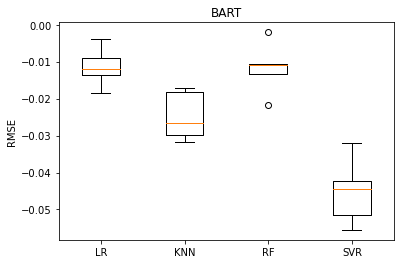

LR: -0.023926 (0.015715)
KNN: -0.028240 (0.023150)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.026246 (0.020488)
SVR: -0.045624 (0.014040)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

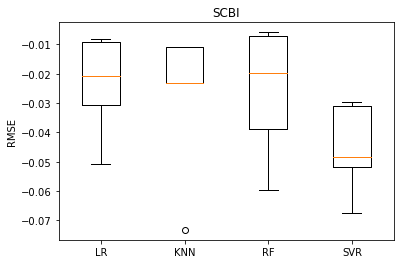

LR: -0.018997 (0.025015)
KNN: -0.027205 (0.026454)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.021404 (0.027750)
SVR: -0.038182 (0.025074)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

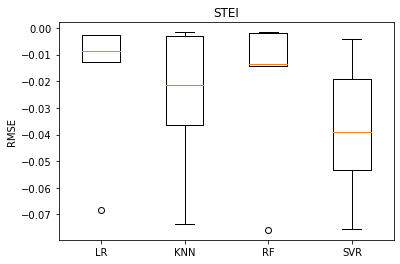

LR: -0.002092 (0.000406)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KNN: -0.001765 (0.000689)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.001826 (0.000770)
SVR: -0.002474 (0.001378)


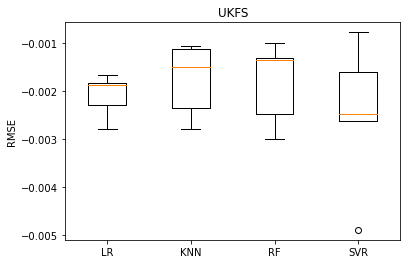

LR: -0.011889 (0.002838)
KNN: -0.019829 (0.005874)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.013581 (0.008038)
SVR: -0.034789 (0.013354)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

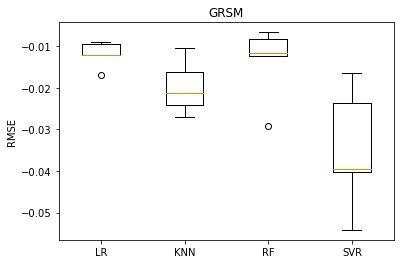

LR: -0.006415 (0.002775)
KNN: -0.015158 (0.005582)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.007808 (0.002990)
SVR: -0.025482 (0.009454)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

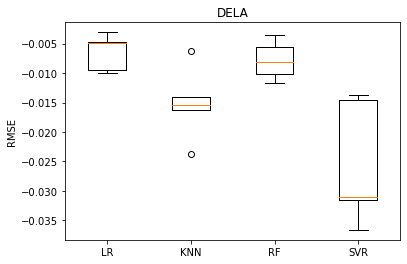

LR: -0.014432 (0.018577)
KNN: -0.015868 (0.010874)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

RF: -0.014690 (0.011827)
SVR: -0.020771 (0.011829)


C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\palde\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

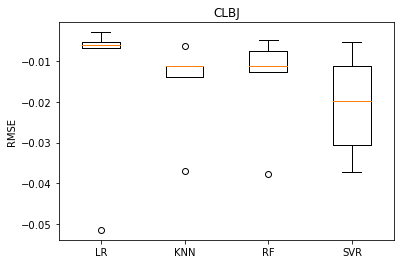

In [18]:
#Compare different models
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('SVR', SVR()))

for k in range(0,8):
    X_train = site_data[k][site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = site_data[k][site_data[k].columns.intersection(target_variables)].loc[:'2019', :]
    results = []
    names = []
    for name, model in models:
        tscv = TimeSeriesSplit(n_splits = 5)
        cv_results = cross_val_score(model, X_train, Y_train, cv= tscv, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
    plt.boxplot(results, labels = names)
    plt.title(site_list[k])
    plt.ylabel("RMSE")
    plt.show()

In [23]:
#Train the models with Random Forest Regressor
best_models = []
overall_rmse_score = []
overall_r2_score = []
target_variable_wise_score = []
true_results = []
predicted_results = []

for k in range(0,8):
    print("\n" + str(site_list[k]) + ":\n")
    X_train = site_data[k][site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(site_data[k][site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = site_data[k][site_data[k].columns.intersection(input_features)].loc['2020', :]
    Y_test = np.ravel(site_data[k][site_data[k].columns.intersection(target_variables)].loc['2020', :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [5, 8, 10, 12, 15, 20, 30, 50, 60, 80],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,20)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score.append(rmse)
    overall_r2_score.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


HARV:

Shape of X_train:(659, 19)
Shape of Y_train:(659,)
Shape of X_test:(272, 19)
Shape of Y_test:(272,)
RMSE of Training Data: -0.0165405361149808
Model:RandomForestRegressor(max_depth=12, max_features=0.1, n_estimators=50,
                      random_state=0)
explained_variance: 0.9718648340472807
RMSE: 0.0079751350454869
R2: 0.971823330933389
------------------------------------------------------------------------

BART:

Shape of X_train:(582, 19)
Shape of Y_train:(582,)
Shape of X_test:(271, 19)
Shape of Y_test:(271,)
RMSE of Training Data: -0.01087571961223126
Model:RandomForestRegressor(max_depth=12, max_features=0.1, n_estimators=12,
                      random_state=0)
explained_variance: 0.9623716799062759
RMSE: 0.00829201555530111
R2: 0.9623645714402498
------------------------------------------------------------------------

SCBI:

Shape of X_train:(561, 19)
Shape of Y_train:(561,)
Shape of X_test:(331, 19)
Shape of Y_test:(331,)
RMSE of Training Data: -0.0183357134544

In [24]:
site_list_modified = list(site_list[:4]) + list(site_list[5:])
overall_rmse_score_modified = list(overall_rmse_score[:4]) + list(overall_rmse_score[5:])
overall_r2_score_modified = list(overall_r2_score[:4]) + list(overall_r2_score[5:])

fig, ax = plt.subplots(1, 2, figsize = (40, 12), dpi=80)
fig.suptitle("Site- wise Overall Performance Evaluation", fontsize=30, fontweight='bold')
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_ylabel("RMSE", fontsize = 26)
ax[0].set_ylim(0.005, 0.020)
ax[0].set_title("Root Mean Squared Error", fontsize = 32) 
ax[0].plot(site_list_modified, overall_rmse_score_modified, color = 'black', marker='o')
ax[0].yaxis.grid()

ax[1].set_ylabel("R-Squared Score", fontsize = 30)
ax[1].set_title("R-Squared Score", fontsize = 32)
ax[1].set_ylim(0.60, 1.00)
ax[1].plot(site_list_modified, overall_r2_score_modified, color = 'black', marker='o')
#ax[1].axhline(y=0.85, linestyle = "--")
ax[1].tick_params(axis='both', which='major', labelsize = 30)
ax[1].yaxis.grid()
pdf.savefig()
plt.close()

In [25]:
fig, ax = plt.subplots(4, 2, figsize = (40, 50))
ax = ax.flatten()
fig.suptitle("Feature Importances", fontsize=26, fontweight='bold')
for k in range(0,8):
    imp = best_models[k].feature_importances_
    indices = np.argsort(imp)
    #features = X_train.columns
    ax[k].set_title(site_list[k], fontsize=20, fontweight='bold')
    ax[k].barh(range(len(indices)), imp[indices], color = 'b', align='center')
    ax[k].set_yticks(range(len(indices)))
    ax[k].set_yticklabels([input_features[i] for i in indices])
    ax[k].set_xlabel("Relative Importance", fontsize = 18) 
    ax[k].tick_params(axis='both', which='major', labelsize=16)
plt.subplots_adjust(top=0.95)
pdf.savefig()
plt.close()

## Validation

In [26]:
# Test with 2020 data
predicted_site_data = []
for k in range(0,8):
    predicted_site_data.append(site_data[k].loc['2020', :])

In [27]:
for k in range(0,8):
    Y_pred = predicted_results[k]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90", value = Y_pred)
#    for i in range(1,35):
#        predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
#        predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = predicted_col_name, 
#                                      value = Y_pred[:, i])

In [28]:
fig, ax = plt.subplots(8, 1, figsize = (40, 120))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc", fontsize=26, fontweight='bold')
for k in range(6,8):
    df = predicted_site_data[k]
    df = df.reset_index()
    ax[k].set_title(site_list[k], fontsize=20, fontweight='bold')
    ax[k].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'black', lw=1, marker = 'o')
    ax[k].set_xlabel("Date", fontsize = 22) 
    ax[k].set_ylim(-0.06,0.06)
    #ax[k].set_yticks(np.arange(-0.06,0.06), 0.01)
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=20)
    ax[k].set_ylabel("Difference between true and predicted gcc_90", fontsize = 22)
plt.subplots_adjust(top=0.95)
pdf.savefig()
plt.close()

In [29]:
fig, ax = plt.subplots(4, 2, figsize = (40, 60))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc", fontsize=26, fontweight='bold')
for k in range(0,8):
    df = predicted_site_data[k]
    df = df.reset_index()
    ax[k].set_title(site_list[k], fontsize=20, fontweight='bold')
    ax[k].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
    ax[k].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
    ax[k].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
    ax[k].set_xlabel("Date", fontsize = 18) 
    ax[k].set_yticks(np.arange(0.3, 0.5), 0.02)
    fig.suptitle("True vs. Predicted vs. Baseline gcc", fontsize=26, fontweight='bold')
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].set_ylabel("gcc_90", fontsize = 20)
    ax[k].legend()
    ax[k].tick_params(axis='both', which='major', labelsize=16)
    ax[k].yaxis.grid()
plt.subplots_adjust(top=0.95)
pdf.savefig()
plt.close()

<ipython-input-29-0ba1f83e648f>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[k].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-0ba1f83e648f>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[k].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-0ba1f83e648f>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[k].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-0ba1f83e648f>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [30]:
# Predict gcc_90 for 2020
predictions_2020 = pd.DataFrame()
for k in range(0,8):
    predictions_2020 = predictions_2020.append(predicted_site_data[k][predicted_site_data[k].columns.intersection(['siteID', 'predicted_gcc_90'])].reset_index())

last_year_df = dataset[dataset.columns.intersection(['siteID', 'gcc_sd'])].loc['2019',:].reset_index()
last_year_df['time'] = last_year_df['time'].mask(last_year_df['time'].dt.year == 2019, 
                             last_year_df['time'] + pd.offsets.DateOffset(year=2020))
last_year_df = last_year_df.ffill(axis=0)

final_pred_2020 = pd.merge(left=predictions_2020, right=last_year_df, how='left', left_on=['time','siteID'], right_on=['time','siteID'])


C:\Users\palde\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:691: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(


In [31]:
pdf.close()

In [32]:
site_list

array(['HARV', 'BART', 'SCBI', 'STEI', 'UKFS', 'GRSM', 'DELA', 'CLBJ'],
      dtype=object)

In [33]:
best_models

[RandomForestRegressor(max_depth=12, max_features=0.1, n_estimators=50,
                       random_state=0),
 RandomForestRegressor(max_depth=12, max_features=0.1, n_estimators=12,
                       random_state=0),
 RandomForestRegressor(max_depth=11, max_features=0.3, n_estimators=8,
                       random_state=0),
 RandomForestRegressor(max_depth=14, max_features=0.1, n_estimators=50,
                       random_state=0),
 RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=10,
                       random_state=0),
 RandomForestRegressor(max_depth=10, max_features=0.1, n_estimators=50,
                       random_state=0),
 RandomForestRegressor(max_depth=6, max_features=0.2, n_estimators=10,
                       random_state=0),
 RandomForestRegressor(max_depth=18, max_features=0.3, n_estimators=5,
                       random_state=0)]

In [ ]:
# Train UKFS
UKFS_X_train = site_data[4][site_data[4].columns.intersection(input_features)]
UKFS_y_train = np.ravel(site_data[4][site_data[4].columns.intersection(target_variables)])

model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [5, 8, 10, 12, 15, 20, 30, 50, 60, 80],
    'max_features': ['auto', 'sqrt','log2', 0.1,0.2,0.3,0.4],
    'max_depth': [i for i in range(5,20)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models[4] = best_model
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

In [31]:
# Save the models for each of the site
for k in range(0,8):
    file_name = "model_"+site_list[k]+".pkl"
    pickle.dump(best_models[k], open(file_name, 'wb'))